# General Overview - Statistical Analysis

- Are there variables that are particularly significant in terms of explaining the answer to your project question?
- Are there significant differences between subgroups in your data that may be relevant to your project aim?
- Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
- What are the most appropriate tests to use to analyze these relationships?

Use chi square test for categorical variables.

Some categorical variables are nominal attributes, meaning that the variables in each column are independent of each other (i.e. no sense of order). Others are binary and have only two answer choices: Yes and No.

Using Label Encoder or One-Hot Encoder can impact our model results. We can try to use both in order to determine which encoder is the more accurate one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, t, chisquare ## Do I need to do anything with norm and t?
from numpy.random import seed ## Do I need this for anything?
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
data = pd.read_csv('tree_census_stat_ready.csv', index_col=0, encoding='utf-8') # import data
tree = data.copy() # save a copy of data as tree

In [3]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651535 entries, 0 to 683787
Data columns (total 22 columns):
tree_id         651535 non-null int64
tree_dbh        651535 non-null int64
curb_loc        651535 non-null object
health          651535 non-null object
spc_common      651535 non-null object
steward         651535 non-null object
guards          651535 non-null object
sidewalk        651535 non-null object
problems        651535 non-null object
root_stone      651535 non-null object
root_grate      651535 non-null object
root_other      651535 non-null object
trunk_wire      651535 non-null object
trnk_light      651535 non-null object
trnk_other      651535 non-null object
brch_light      651535 non-null object
brch_shoe       651535 non-null object
brch_other      651535 non-null object
borough         651535 non-null object
longitude       651535 non-null float64
latitude        651535 non-null float64
num_problems    651535 non-null int64
dtypes: float64(2), int64(3), ob

In [4]:
# looking at sample data

tree.head()

,tree_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,problems,root_stone,...,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,180683,3,OnCurb,Fair,red maple,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Queens,-73.844215,40.723092,0
1,200540,21,OnCurb,Fair,pin oak,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Queens,-73.818679,40.794111,1
2,204026,3,OnCurb,Good,honeylocust,1or2,None,Damage,None,No,...,No,No,No,No,No,No,Brooklyn,-73.936608,40.717581,0
3,204337,10,OnCurb,Good,honeylocust,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.934456,40.713537,1
4,189565,21,OnCurb,Good,American linden,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.975979,40.666778,1


The problems column is reflected in the adjacent 9 columns so we are removing it from our dataset along with longitude and latitude since they are used to map the location of the trees. We do not need the latitude and longitude columns either since they are used to map the location of the tree, see data storytelling for the maps. Finally, we are removing tree_id since the trees are identified using their index number.

In [5]:
col_remove = ['tree_id', 'problems', 'longitude', 'latitude'] # columns to remove

tree = tree.drop(col_remove, axis=1)

In [6]:
# cleaned up dataset

tree.head(10)

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,num_problems
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Queens,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Queens,1
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
5,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,No,No,No,No,No,No,Manhattan,0
6,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,No,No,No,No,No,No,Manhattan,0
7,9,OnCurb,Good,American linden,None,None,NoDamage,No,Yes,No,No,No,No,No,No,No,Manhattan,1
8,6,OnCurb,Good,honeylocust,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Staten Island,0
9,21,OffsetFromCurb,Fair,London planetree,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Brooklyn,0


# Statistical Testing - Chi-Square Test for Association

We are interested in discovering if there is a relationship between two categorical variables and for that, we will use the chi square test for association.

## Curb Location (curb_loc)

In [7]:
# Null Hypothesis: There is no relationship between health and curb_loc (independent).
# Alternate Hypothesis: There is a relationship between health and curb_loc (not independent).
# p-value: 0.05

# using the crosstab function

curb_loc_table = pd.crosstab(tree.curb_loc, [tree.health])
display(curb_loc_table)

health,Fair,Good,Poor
curb_loc,,,
OffsetFromCurb,4022,20814,963
OnCurb,92405,507513,25818


In [8]:
# calcuate expected values

offset_total = len(tree[tree.curb_loc == 'OffsetFromCurb'])
oncurb_total = len(tree[tree.curb_loc == 'OnCurb'])
good_total = len(tree[tree.health == 'Good'])
fair_total = len(tree[tree.health == 'Fair'])
poor_total = len(tree[tree.health == 'Poor'])
grand_total = len(tree)

print('Offset From Curb Total: ', offset_total)
print('On Curb Total: ', oncurb_total)
print('Good Total: ', good_total)
print('Fair Total: ', fair_total)
print('Poor Total: ', poor_total)
print('Grand Total: ', grand_total)

offset_good = (offset_total * good_total) / grand_total
offset_fair = (offset_total * fair_total) / grand_total
offset_poor = (offset_total * poor_total) / grand_total
oncurb_good = (oncurb_total * good_total) / grand_total
oncurb_fair = (oncurb_total * fair_total) / grand_total
oncurb_poor = (oncurb_total * poor_total) / grand_total

Offset From Curb Total:  25799
On Curb Total:  625736
Good Total:  528327
Fair Total:  96427
Poor Total:  26781
Grand Total:  651535


In [9]:
# calculate chi-square values using observed and expected values

observed = [20814, 4022, 963, 507513, 92405, 25818] # offset good, fair, poor, oncurb good, fair, poor
expected = [offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor]

values = []

for e, o in enumerate(observed):
    sig = (o - expected[e])**2 / expected[e]
    values.append(sig)
    
chisq_curb_loc = sum(values)
print('Chi-squared value: ', chisq_curb_loc)

Chi-squared value:  21.208951781289166


Next, we find a p-value associated with the chi-squared value that tells us if the difference between the observed and associated values are statistically significant.

In [10]:
# using chisquare

observed = np.array([20814, 4022, 963, 507513, 92405, 25818]) # offset good, fair, poor, oncurb good, fair, poor
expected = np.array([offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor])

chisquare_value, pvalue = chisquare(observed, expected)

print('Chi-squared value: ', chisquare_value) # confirmed!
print('Curb_loc p-value: ', pvalue)

Chi-squared value:  21.208951781289166
Curb_loc p-value:  0.0007396291269688524


The calculated p-value of 0.0007 tells us that we can reject the null hypothesis and accept the alternate hypothesis that there is a relationship between the curb location and tree health.

## Stewardship

In [11]:
# Null Hypothesis: There is no relationship between health and steward.
# Alternate Hypothesis: There is a relationship between health and steward.
# p-value: 0.05

# using the crosstab function

steward_table = pd.crosstab(tree.steward, [tree.health])
display(steward_table)

health,Fair,Good,Poor
steward,,,
1or2,21883,115231,6276
3or4,2829,15594,747
4orMore,200,1360,49
None,71515,396142,19709


In [12]:
# using a shortcut, chi2_contingency

from scipy.stats import chi2_contingency

chisq_value, pvalue, df, expected = chi2_contingency(steward_table)

print('Chi-square value: ', chisq_value)
print('Steward p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  82.64204316499212
Steward p-value:  1.0158580809907348e-15


## Guards

In [13]:
# Null Hypothesis: There is no relationship between health and guards.
# Alternate Hypothesis: There is a relationship between health and guards.
# p-value: 0.05

guard_table = pd.crosstab(tree.guards, [tree.health])
display(guard_table)

health,Fair,Good,Poor
guards,,,
Harmful,3836,15313,1091
Helpful,7159,42602,2061
None,84057,464503,23169
Unsure,1375,5909,460


In [14]:
chisq_value, pvalue, df, expected = chi2_contingency(steward_table)

print('Chi-square value: ', chisq_value)
print('Guard p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  82.64204316499212
Guard p-value:  1.0158580809907348e-15


## Sidewalk Condition

In [15]:
# Null Hypothesis: There is no relationship between health and sidewalks.
# Alternate Hypothesis: There is a relationship between health and sidewalks.
# p-value: 0.05

sidewalk_table = pd.crosstab(tree.sidewalk, [tree.health])
display(sidewalk_table)

health,Fair,Good,Poor
sidewalk,,,
Damage,28676,151750,6593
NoDamage,67751,376577,20188


In [16]:
chisq_value, pvalue, df, expected = chi2_contingency(sidewalk_table)

print('Chi-square value: ', chisq_value)
print('Guard p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  268.98082116629007
Guard p-value:  3.9044225721239635e-59


## Borough

In [17]:
# Null Hypothesis: There is no relationship between health and borough.
# Alternate Hypothesis: There is a relationship between health and borough.
# p-value: 0.05

borough_table = pd.crosstab(tree.borough, [tree.health])
display(borough_table)

health,Fair,Good,Poor
borough,,,
Bronx,10879,66546,3092
Brooklyn,25060,138119,6454
Manhattan,11456,47338,3607
Queens,34512,193789,9401
Staten Island,14520,82535,4227


In [18]:
chisq_value, pvalue, df, expected = chi2_contingency(borough_table)

print('Chi-square value: ', chisq_value)
print('Borough p-value: ', pvalue) # very safe to reject the null hypothesis

Chi-square value:  1387.3756826254964
Borough p-value:  3.0368189425788952e-294


## root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

In [19]:
# these 9 columns are similar to each other (binaries) so we are creating a function to handle all of them at once

root_trunk_branch = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

rt_tk_bh_values = []

for x in root_trunk_branch:
    table = pd.crosstab(tree[x], [tree.health])
    chisq_value, pvalue, df, expected = chi2_contingency(table)
    rt_tk_bh_values.extend(('Column: ' + x, 'Chi-square: ', chisq_value, 'p-value:', pvalue, '-----------'))

In [20]:
display(rt_tk_bh_values)

['Column: root_stone',
 'Chi-square: ',
 602.1719849387213,
 'p-value:',
 1.7378604199012528e-131,
 '-----------',
 'Column: root_grate',
 'Chi-square: ',
 356.68976230775087,
 'p-value:',
 3.5140039001739447e-78,
 '-----------',
 'Column: root_other',
 'Chi-square: ',
 1928.3000460610629,
 'p-value:',
 0.0,
 '-----------',
 'Column: trunk_wire',
 'Chi-square: ',
 511.1079115744369,
 'p-value:',
 1.0335397233161574e-111,
 '-----------',
 'Column: trnk_light',
 'Chi-square: ',
 42.65188376759023,
 'p-value:',
 5.473449537752943e-10,
 '-----------',
 'Column: trnk_other',
 'Chi-square: ',
 11787.16656714847,
 'p-value:',
 0.0,
 '-----------',
 'Column: brch_light',
 'Chi-square: ',
 410.2875656415676,
 'p-value:',
 8.07582918010992e-90,
 '-----------',
 'Column: brch_shoe',
 'Chi-square: ',
 35.43604272124426,
 'p-value:',
 2.01911517512005e-08,
 '-----------',
 'Column: brch_other',
 'Chi-square: ',
 15111.455650416505,
 'p-value:',
 0.0,
 '-----------']

The p-values all show that there is statistical significance between each of the nine columns and tree health.

## Tree Relationship Tables

Let's take a look at the relationships between various variables.

In [21]:
pd.crosstab([tree.sidewalk, tree.borough, tree.health], [tree.steward, tree.guards, tree.curb_loc])

steward                                 1or2                               \
guards                               Harmful               Helpful          
curb_loc                      OffsetFromCurb OnCurb OffsetFromCurb OnCurb   
sidewalk borough       health                                               
Damage   Bronx         Fair                0     38              4    116   
                       Good                0    151             14    586   
                       Poor                0     17              1     36   
         Brooklyn      Fair               30    295              5    468   
                       Good               26   1186             19   2707   
                       Poor                1     65              0     99   
         Manhattan     Fair                9    343              3    420   
                       Good                9   1154             14   1665   
                       Poor                2     78              1    140   
         Queens        Fair                1    228              1    149   
                       Good                1    801              4    821   
                       Poor                0     77              0     46   
         Staten Island Fair                0     38              0     55   
                       Good                0    140              6    224   
                       Poor                0      6              0     10   
NoDamage Bronx         Fair                1     49             14    298   
                       Good                2    240             56   1978   
                       Poor                0     27              3     71   
         Brooklyn      Fair               14    348             14   1096   
                       Good               26   1448            184   7173   
                       Poor                1     93              5    267   
         Manhattan     Fair               27    689             34   1280   
                       Good               75   2604            299   6178   
                       Poor                3    220             10    448   
         Queens        Fair                2    231             15    462   
                       Good                4   1095             40   2961   
                       Poor                0    108              0    145   
         Staten Island Fair                0     94              2    161   
                       Good                7    481             47   1294   
                       Poor                0     33              0     27   

steward                                                                    \
guards                                  None                Unsure          
curb_loc                      OffsetFromCurb OnCurb OffsetFromCurb OnCurb   
sidewalk borough       health                                               
Damage   Bronx         Fair               12    395              0     12   
                       Good               64   1915              0     65   
                       Poor                3    111              0      2   
         Brooklyn      Fair               54   1052              0     54   
                       Good              265   5745              2    368   
                       Poor               12    272              0     18   
         Manhattan     Fair               10    348              0     57   
                       Good               56   1150              2    156   
                       Poor                4     91              0     19   
         Queens        Fair               36    956              0    137   
                       Good              114   5582              5    553   
                       Poor                5    253              0     59   
         Staten Island Fair               15    378              2     39   
                       Good               43   1919              1     8

In [22]:
pd.crosstab([tree.sidewalk, tree.steward, tree.guards], [tree.borough, tree.health])

borough                  Bronx              Brooklyn              Manhattan  \
health                    Fair   Good  Poor     Fair   Good  Poor      Fair   
sidewalk steward guards                                                       
Damage   1or2    Harmful    38    151    17      325   1212    66       352   
                 Helpful   120    600    37      473   2726    99       423   
                 None      407   1979   114     1106   6010   284       358   
                 Unsure     12     65     2       54    370    18        57   
         3or4    Harmful     2     13     1       39    201     3       168   
                 Helpful     6     64     4      144   1026    19       217   
                 None        5     26     0       31    161     4        13   
                 Unsure      3      6     1       20     97     1        26   
         4orMore Harmful     0      1     0        1     12     1         7   
                 Helpful     1      6     0        5     72     1        11   
                 None        0     10     1        1     11     0         1   
                 Unsure      0      0     0        0      6     0         5   
         None    Harmful    23    118     7       86    459    16        84   
                 Helpful    18    189     6       77    613    25        47   
                 None     2711  15984   632     6183  34770  1363      1449   
                 Unsure      8     49     4       18    202     8        13   
NoDamage 1or2    Harmful    50    242    27      362   1474    94       716   
                 Helpful   312   2034    74     1110   7357   272      1314   
                 None     1153   6821   359     2938  15937   774      1147   
                 Unsure     37    130    10      118    632    29       103   
         3or4    Harmful     6     36     2       62    368    17       250   
                 Helpful    43    277    15      368   2627    74       650   
                 None       56    246    15       72    507    19        32   
                 Unsure      4     21     3       23    154     6        59   
         4orMore Harmful     0      4     0        6     26     1        10   
                 Helpful     4     17     1       37    280     6        39   
                 None        1     21     0        7     49     0         3   
                 Unsure      1      3     0        2      7     1         4   
         None    Harmful    63    167     8      130    644    43       205   
                 Helpful    77    667    30      191   1782    73       181   
                 None     5692  36515  1711    11039  58082  3122      3491   
                 Unsure     26     84    11       32    245    15        21   

borough                               Queens               Staten Island  \
health                     Good  Poor   Fair    Good  Poor          Fair   
sidewalk steward guards                                                    
Damage   1or2    Harmful   1163    80    229     802    77            38   
                 Helpful   1679   141    150     825    46            55   
                 None      1206    95    992    5696   258           393   
                 Unsure     158    19    137     558    59            41   
         3or4    Harmful    588    35     18      77     6             4   
                 Helpful    727    55     25     169     5             1   
                 None        27     2     29     157     5            13   
                 Unsure     108    10     11      35     7             1   
         4orMore Harmful     20     1      2       8     1             0   
                 Helpful     63     3      3      25     2             0   
                 None         4     0      4      34     3             1   
                 Unsure      12     0      4       4     0             1   
         None    Harmful    276    18     48     216     6            10   
                 H

In [23]:
pd.crosstab(tree.borough, [tree.steward, tree.sidewalk])

steward         1or2            3or4          4orMore            None         
sidewalk      Damage NoDamage Damage NoDamage  Damage NoDamage Damage NoDamage
borough                                                                       
Bronx           3542    11249    131      724      19       52  19749    45051
Brooklyn       12743    31097   1746     4297     110      422  43820    75398
Manhattan       5731    18435   1976     5841     127      427   7190    22674
Queens          9829    31976    544     2517      90      250  56430   136066
Staten Island   3035    15753    196     1198      20       92  19991    60997

# Analyzing Diameter Distributions

Most of our data consists of categorical variables, only two columns, tree_dbh and num_problems, consist of numerical variables. Let's take a look at the distribution of tree_dbh, tree diameters in inches.

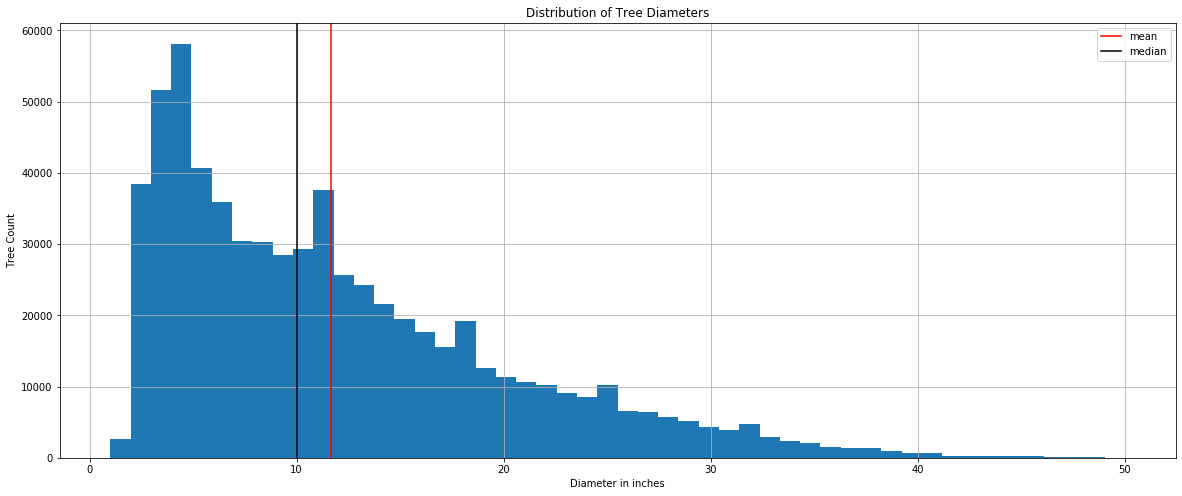

In [24]:
plt.figure(figsize=(20, 8))
tree.tree_dbh.hist(bins=50)
plt.xlabel('Diameter in inches')
plt.ylabel('Tree Count')
plt.title('Distribution of Tree Diameters')
plt.axvline(np.mean(tree.tree_dbh), color='r', label='mean')
plt.axvline(np.median(tree.tree_dbh), color='k', label='median')
plt.legend()
plt.show()

In [25]:
# printing the mean and median

print('Mean Value: ', np.mean(tree.tree_dbh))
print('Median Value: ', np.median(tree.tree_dbh))

Mean Value:  11.674665213687677
Median Value:  10.0


In [26]:
np.percentile(tree.tree_dbh, [2.5, 97.5]) # 95% of values are between 2 and 32

array([ 2., 32.])

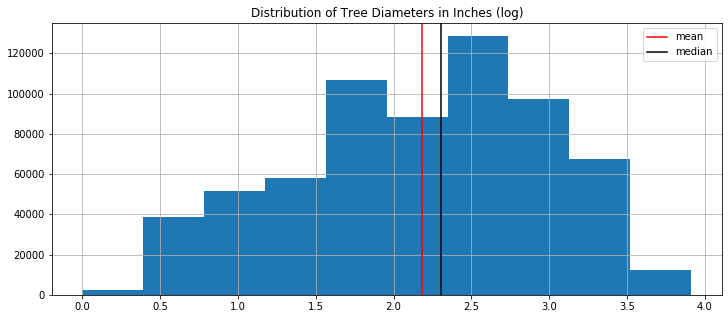

In [27]:
# take the log of tree_dbh

dbh_log = np.log(tree.tree_dbh)

plt.figure(figsize=(12, 5))
dbh_log.hist()
plt.title('Distribution of Tree Diameters in Inches (log)')
plt.axvline(np.mean(dbh_log), color='r', label='mean')
plt.axvline(np.median(dbh_log), color='k', label='median')
plt.legend()
plt.show() # the distribution appears closer to normal after taking the log

Taking the log of the diameters, the distribution is slightly skewed to the left but is closer to a normal distribution than previously.

In [28]:
# diameter (inches) distribution

tree.groupby('health')['tree_dbh'].describe()

,count,mean,std,min,25%,50%,75%,max
health,,,,,,,,
Fair,96427.0,10.954370,7.61766,1.0,5.0,9.0,15.0,50.0
Good,528327.0,11.942466,8.53741,1.0,5.0,10.0,17.0,50.0
Poor,26781.0,8.985064,6.74574,1.0,4.0,7.0,12.0,50.0


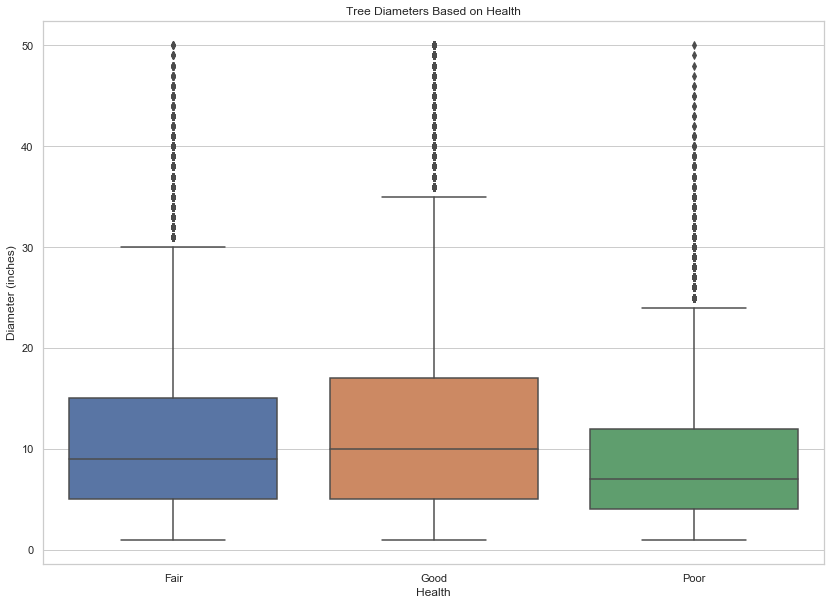

In [29]:
diadata = tree[['health', 'tree_dbh']]

sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))
ax = sns.boxplot(x='health', y='tree_dbh', data=diadata)
ax.set_xlabel('Health')
ax.set_ylabel('Diameter (inches)')
ax.set_title('Tree Diameters Based on Health')
plt.show()

In [30]:
# look into the correlation, tree diameters can explain the health of a tree

In [31]:
## Unbalanced data set - handle this in the machine learning
## Oversampling or undersampling or random sampling

## Statistical analysis is not for target variables

## Stratified sampling - happens during machine learning
## Python has lots of APIs to apply stratified sampling

## Analyzing Problems Distribution

In [32]:
tree.num_problems.describe()

count    651535.000000
mean          0.472087
std           0.754487
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           9.000000
Name: num_problems, dtype: float64

In [33]:
pd.crosstab(tree.health, [tree.num_problems])

num_problems,0,1,2,3,4,5,6,7,8,9
health,,,,,,,,,,
Fair,53915,27984,10436,3275,717,84,15,1,0,0
Good,356491,127845,34377,8011,1479,105,18,1,0,0
Poor,15486,6579,2901,1414,324,59,16,0,1,1


While the number of problems a tree has decreases as the problems increases, after 7 problems, two poor trees have 8 or 9 problems. Overall, there are far less poor trees than good or fair trees.

In [34]:
pd.crosstab([tree.health, tree.root_stone, tree.root_grate, tree.root_other, tree.trunk_wire], 
                    [tree.trnk_light, tree.trnk_other, tree.brch_light, tree.brch_shoe, tree.brch_other])

trnk_light                                              No                \
trnk_other                                              No                 
brch_light                                              No                 
brch_shoe                                               No       Yes       
brch_other                                              No   Yes  No Yes   
health root_stone root_grate root_other trunk_wire                         
Fair   No         No         No         No           53915  2848  19   4   
                                        Yes            753    80   0   0   
                             Yes        No            2111   465   2   0   
                                        Yes             47    12   0   1   
                  Yes        No         No             433    90   2   0   
                                        Yes             11     1   0   0   
                             Yes        No              38    14   0   0   
                                        Yes              0     0   0   0   
       Yes        No         No         No           14124  1156  17   3   
                                        Yes            266    26   2   0   
                             Yes        No             761   189   5   1   
                                        Yes              8     8   0   0   
                  Yes        No         No              40     5   0   0   
                                        Yes              2     0   0   0   
                             Yes        No               7     2   0   0   
                                        Yes              0     0   0   0   
Good   No         No         No         No          356491  4560  77   8   
                                        Yes           3155   202   3   0   
                             Yes        No            8810   883   7   0   
                                        Yes            268    39   0   0   
                  Yes        No         No            1555    94   2   0   
                                        Yes             23     3   0   0   
                             Yes        No             103    24   0   0   
                                        Yes              1     3   0   0   
       Yes        No         No         No           78594  2330  72  12   
                                        Yes           1139    60   1   0   
                             Yes        No            3569   500   8   0   
                                        Yes            113    19   0   0   
                  Yes        No         No             157    13   1   0   
                                        Yes              9     0   0   0   
                             Yes        No              26     1   0   0   
                                        Yes              0     0   0   0   
Poor   No         No         No         No           15486   940   7   1   
                                        Yes            184    32   1   0   
                             Yes        No             486   155   1   0   
                                        Yes              9     4   0   0   
                  Yes        No         No             110    24   0   0   
                                        Yes              0     1   0   0   
                             Yes        No              18     8   0   0   
                                        Yes              0     0   0   0   
       Yes        No         No         No            2858   298   7   2   
                                        Yes             50    13   0   0   
                             Yes        No             132    54   0   0   
                                        Yes              3     5   0   0   
                  Yes        No         No              10     1   0   0   
                                        Yes              2     2   0   0   
                             Yes        No      

# Encoding Categorical Data - Label Encoder

In [35]:
# create a table specifically for label encoding

tree_labeled = tree.copy()

## root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

We'll start by looking at the root, trunk, and branch columns. Since each of these columns contain simple Yes or No options, we create a new column with labels indicating **0 for No and 1 for Yes**.

In [36]:
# transform and map root_stone

rs_le = LabelEncoder()
rs_labels = rs_le.fit_transform(tree_labeled.root_stone)
tree_labeled['root_stone_labels'] = rs_labels

In [37]:
# function to transform and map remaining columns

cols_transform = ['root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

for x in cols_transform:
    lencode = LabelEncoder()
    tree_labeled[x + '_labels'] = lencode.fit_transform(tree_labeled[x])

In [38]:
# display columns with labels

## remove original columns, keep the _labels

tree_labeled[['root_stone', 'root_stone_labels', 'root_grate', 'root_grate_labels', 'root_other', 'root_other_labels', 'trunk_wire', 'trunk_wire_labels', 'trnk_light', 'trnk_light_labels', 'trnk_other', 'trnk_other_labels', 'brch_light', 'brch_light_labels', 'brch_shoe', 'brch_shoe_labels', 'brch_other', 'brch_other_labels']].head()

,root_stone,root_stone_labels,root_grate,root_grate_labels,root_other,root_other_labels,trunk_wire,trunk_wire_labels,trnk_light,trnk_light_labels,trnk_other,trnk_other_labels,brch_light,brch_light_labels,brch_shoe,brch_shoe_labels,brch_other,brch_other_labels
0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
1,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
2,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
3,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
4,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0


In [39]:
# overall view

tree_labeled.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,...,num_problems,root_stone_labels,root_grate_labels,root_other_labels,trunk_wire_labels,trnk_light_labels,trnk_other_labels,brch_light_labels,brch_shoe_labels,brch_other_labels
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0


Next, we use the label encoder for the other columns.

## Curb Location (curb_loc), Stewards, Guards, Sidewalk, and Borough

In [40]:
## use the same encoder for all categorical variables

We assign a numerical value for each categorical answer and display the mapping.

In [41]:
# mapping each column individually

# cols_encode = ['curb_loc', 'steward', 'guards', 'sidewalk', 'borough', 'health']

# cat_mapping = []

# for x in cols_encode:
#     lencode = LabelEncoder()
#     tree[x + '_labels'] = lencode.fit_transform(tree[x])
#     mapped = {index: label for index, label in enumerate(lencode.classes_)}
#     cat_mapping.extend(('Column Name: ' + x, mapped))

In [42]:
# display(cat_mapping)

## these variables are nominal, but should they still be assigned to a certain number? Could some be ordinal?
## Ex. for health, should poor be assigned 0 instead of 2?

## Manually encoding works!

## borough variables are not in any order, they do not have different weights based on which borough they are in
## consider rearranging depending on which borough has the most trees?

In [43]:
# creating a custom mapping scheme

curb_loc_map = {'OffsetFromCurb': 0, 'OnCurb': 1}
steward_map = {'None': 0, '1or2': 1, '3or4': 2, '4orMore': 3}
guards_map = {'None': 0, 'Harmful': 1, 'Unsure': 2, 'Helpful': 3}
sidewalk_map = {'Damage': 0, 'NoDamage': 1}
borough_map = {'Bronx': 0, 'Brooklyn': 1, 'Manhattan': 2, 'Queens': 3, 'Staten Island': 4}
health_map = {'Poor': 0, 'Fair': 1, 'Good': 2}

tree_labeled['curb_loc_labels'] = tree_labeled['curb_loc'].map(curb_loc_map)
tree_labeled['steward_labels'] = tree_labeled['steward'].map(steward_map)
tree_labeled['guards_labels'] = tree_labeled['guards'].map(guards_map)
tree_labeled['sidewalk_labels'] = tree_labeled['sidewalk'].map(sidewalk_map)
tree_labeled['borough_labels'] = tree_labeled['borough'].map(borough_map)
tree_labeled['health_labels'] = tree_labeled['health'].map(health_map)

In [44]:
# display part of the result

tree_labeled[['health', 'health_labels', 'curb_loc', 'curb_loc_labels', 'steward', 'steward_labels', 'guards', 'guards_labels', 'sidewalk', 'sidewalk_labels', 'borough', 'borough_labels']].head()

,health,health_labels,curb_loc,curb_loc_labels,steward,steward_labels,guards,guards_labels,sidewalk,sidewalk_labels,borough,borough_labels
0,Fair,1,OnCurb,1,None,0,None,0,NoDamage,1,Queens,3
1,Fair,1,OnCurb,1,None,0,None,0,Damage,0,Queens,3
2,Good,2,OnCurb,1,1or2,1,None,0,Damage,0,Brooklyn,1
3,Good,2,OnCurb,1,None,0,None,0,Damage,0,Brooklyn,1
4,Good,2,OnCurb,1,None,0,None,0,Damage,0,Brooklyn,1


## Tree Types (spc_common)

There are 132 unique kinds of trees. The number of trees vastly outnumber the answer types for the other columns so we are choosing not to use spc_common as a factor for our model.

In [45]:
print('Number of unique trees:', len(tree.spc_common.unique()))

Number of unique trees: 132


# Combining the Columns

In [46]:
# reorganize the dataset so that label columns are next to their original columns

tree_labeled = pd.concat([tree_labeled[['health',
                               'health_labels',
                               'num_problems',
                               'tree_dbh', 
                               'curb_loc', 
                               'curb_loc_labels', 
                               'steward', 
                               'steward_labels', 
                               'guards', 
                               'guards_labels', 
                               'sidewalk', 
                               'sidewalk_labels', 
                               'borough', 
                               'borough_labels',
                               'root_stone', 
                               'root_stone_labels', 
                               'root_grate', 
                               'root_grate_labels',
                               'root_other', 
                               'root_other_labels', 
                               'trunk_wire', 
                               'trunk_wire_labels', 
                               'trnk_light', 
                               'trnk_light_labels', 
                               'trnk_other', 
                               'trnk_other_labels', 
                               'brch_light', 
                               'brch_light_labels', 
                               'brch_shoe', 
                               'brch_shoe_labels', 
                               'brch_other', 
                               'brch_other_labels', 
                              ]]], axis=1)

tree_labeled.head(10)

,health,health_labels,num_problems,tree_dbh,curb_loc,curb_loc_labels,steward,steward_labels,guards,guards_labels,...,trnk_light,trnk_light_labels,trnk_other,trnk_other_labels,brch_light,brch_light_labels,brch_shoe,brch_shoe_labels,brch_other,brch_other_labels
0,Fair,1,0,3,OnCurb,1,None,0,None,0,...,No,0,No,0,No,0,No,0,No,0
1,Fair,1,1,21,OnCurb,1,None,0,None,0,...,No,0,No,0,No,0,No,0,No,0
2,Good,2,0,3,OnCurb,1,1or2,1,None,0,...,No,0,No,0,No,0,No,0,No,0
3,Good,2,1,10,OnCurb,1,None,0,None,0,...,No,0,No,0,No,0,No,0,No,0
4,Good,2,1,21,OnCurb,1,None,0,None,0,...,No,0,No,0,No,0,No,0,No,0
5,Good,2,0,11,OnCurb,1,1or2,1,Helpful,3,...,No,0,No,0,No,0,No,0,No,0
6,Good,2,0,11,OnCurb,1,1or2,1,Helpful,3,...,No,0,No,0,No,0,No,0,No,0
7,Good,2,1,9,OnCurb,1,None,0,None,0,...,No,0,No,0,No,0,No,0,No,0
8,Good,2,0,6,OnCurb,1,None,0,None,0,...,No,0,No,0,No,0,No,0,No,0
9,Fair,1,0,21,OffsetFromCurb,0,None,0,None,0,...,No,0,No,0,No,0,No,0,No,0


In [47]:
print('The dataset has {} rows and {} columns.'.format(tree_labeled.shape[0], tree_labeled.shape[1]))

The dataset has 651535 rows and 32 columns.


# Encoding Categorical Data - One Hot Encoder

We are encoding the data using one-hot encoder.

In [48]:
tree_onehot = tree.copy()

In [49]:
tree_onehot.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other',
       'borough', 'num_problems'],
      dtype='object')

In [50]:
cols_onehot = ['health', 'curb_loc', 'steward', 
               'guards', 'sidewalk', 'borough']

one_hot_labels = []

for x in cols_onehot:
    lencode = LabelEncoder() # label encoding
    labels = lencode.fit_transform(tree_onehot[x])
    tree_onehot[x + '_labels'] = labels
    ohencode = OneHotEncoder(categories='auto')
    add_array = ohencode.fit_transform(tree_onehot[[x + '_labels']]).toarray()
    listing_labels = list(lencode.classes_)
    label_df = pd.DataFrame(add_array, columns=listing_labels)
    one_hot_labels.append(label_df)
    
# adding labeled one-hot columns



In [51]:
binaries = ['root_stone', 'root_grate', 'root_other', 
               'trunk_wire', 'trnk_light', 'trnk_other', 
               'brch_light', 'brch_shoe', 'brch_other']

one_hot_labels_binaries = []

for x in binaries:
    lencode = LabelEncoder() # label encoding
    labels = lencode.fit_transform(tree_onehot[x])
    tree_onehot[x + '_labels'] = labels
    ohencode = OneHotEncoder(categories='auto')
    add_array = ohencode.fit_transform(tree_onehot[[x + '_labels']]).toarray()
    listing_labels = [x + '_' + str(bin_label)
                     for bin_label in lencode.classes_]
    label_df = pd.DataFrame(add_array, columns=listing_labels)
    one_hot_labels_binaries.append(label_df)
    
one_hot_labels_binaries[3]

,trunk_wire_No,trunk_wire_Yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
651530,1.0,0.0
651531,1.0,0.0
651532,1.0,0.0
651533,1.0,0.0


# Linear Regression

In [52]:
## LR is used for predicting a continuous variable, tree health is not
## LR is not used for this

In [53]:
## Start using Random Forest - works better with categorical data
## Decision Tree
## Logisitic Regression
## SVM